In [33]:
# we use this script in the paper to make the corruption experiment.
from sklearn import datasets, neighbors
from scipy import stats
import numpy as np
import harmonicalignment
import harmonicalignment.math

from shutil import copyfileobj
from six.moves import urllib
import os


def knnclassifier(X, X_labels, Y, Y_labels, knn):
    knn_op = neighbors.KNeighborsClassifier(knn)
    knn_op.fit(X, X_labels)
    return knn_op.score(Y, Y_labels)


np.random.seed(42)
digits = datasets.fetch_openml("mnist_784")
labels = digits["target"]
# imgs = digits["data"]
imgs = np.asarray(digits["data"])

n_samples = 1000
n_features = 784
n_iters = 1
n_percentages = 3
n_wavelets = 2

colreplace_probs = np.linspace(0, 1, n_percentages) if n_percentages > 1 else [1]
# scale of wavelets(eg n_filters) to use
wavelet_scales = [2, 8, 16, 64]
# kernel params
knn_1 = 20
decay_1 = 20
pca_1 = 100
knn_2 = knn_1
decay_2 = decay_1
pca_2 = pca_1
# Z = transformed
knn_transform = 10
decay_transform = 10
pca_transform = None
# diffusion time for final embedding
diffusion_t = 1
#
output = np.zeros((n_percentages, n_iters, n_wavelets, 2))
# store metrics in here
##

for p in range(n_percentages):
    # build random matrix and replace prct of columns with I
    pct = colreplace_probs[p]
    random_rotation = stats.ortho_group.rvs(n_features)
    # random orthogonal rotation
    colReplace = np.random.choice(
        n_features, np.floor(pct * n_features).astype(int), replace=False
    )
    random_rotation[:, colReplace] = np.eye(n_features)[:, colReplace]
    for iter_idx in range(n_iters):
        #  sample two sets of digits from MNIST
        sample_idx = np.random.choice(len(labels), n_samples * 2, replace=False)
        X1_idx = sample_idx[:n_samples]
        X2_idx = sample_idx[n_samples:]
        #  slice the digits
        X1 = imgs[X1_idx, :]
        X2 = imgs[X2_idx, :]
        #  transform X2
        X2_rotate = X2 @ random_rotation.T
        X_combined = np.vstack([X1, X2_rotate])
        U_combined, S_combined = harmonicalignment.math.diffusionCoordinates(
            X_combined, decay_1, knn_1, pca_1
        )
        # this is for evaluating unaligned data.  You can also plot this.
        #  slice the labels
        X1_labels = labels[X1_idx]
        X2_labels = labels[X2_idx]
        combined_labels = np.concatenate([X1_labels, X2_labels])
        #  run pca and classify
        DM_combined = U_combined @ np.diag(np.exp(-S_combined))
        beforeprct = knnclassifier(
            DM_combined[:n_samples, :],
            X1_labels,
            DM_combined[n_samples:, :],
            X2_labels,
            5,
        )
        for scale_idx in range(n_wavelets):
            n_filters = wavelet_scales[scale_idx]
            align_op = harmonicalignment.HarmonicAlignment(
                n_filters,
                t=diffusion_t,
                overlap=2,
                verbose=1,
                knn_X=knn_1,
                knn_Y=knn_2,
                knn_XY=knn_transform,
                decay_X=decay_1,
                decay_Y=decay_2,
                decay_XY=decay_transform,
                n_pca_X=pca_1,
                n_pca_Y=pca_2,
                n_pca_XY=pca_transform,
            )
            align_op.align(X1, X2_rotate)
            Z = align_op.diffusion_map()
            afterprct = knnclassifier(
                Z[:n_samples, :], X1_labels, Z[n_samples:, :], X2_labels, 5
            )
            output[p, iter_idx, scale_idx, 0] = beforeprct
            output[p, iter_idx, scale_idx, 1] = afterprct

print(output)


Calculating eigendecomposition...
Calculated eigendecomposition in 2.27 seconds.
Calculating Harmonic Alignment...
  Calculating diffusion coordinates...
Calculating PCA...
Calculated PCA in 0.14 seconds.
Calculating KNN search...
Calculated KNN search in 0.15 seconds.
Calculating affinities...
Calculated affinities in 0.05 seconds.
    Calculating eigendecomposition...
    Calculated eigendecomposition in 0.29 seconds.
Calculating PCA...
Calculated PCA in 0.13 seconds.
Calculating KNN search...
Calculated KNN search in 0.14 seconds.
Calculating affinities...
Calculated affinities in 0.04 seconds.
    Calculating eigendecomposition...
    Calculated eigendecomposition in 0.30 seconds.
  Calculated diffusion coordinates in 1.46 seconds.
  Calculating wavelets...
  Calculated wavelets in 1.96 seconds.
  Calculating transformed data...
    Calculating graph Laplacian...
Calculating PCA...
Calculated PCA in 0.64 seconds.
Calculating KNN search...
Calculated KNN search in 0.55 seconds.
Calc

In [34]:
# we use this script in the paper to make the corruption experiment.
from sklearn import datasets, neighbors
from scipy import stats
import numpy as np
import harmonicalignment
import harmonicalignment.math

from shutil import copyfileobj
from six.moves import urllib
import os


def knnclassifier(X, X_labels, Y, Y_labels, knn): #输出的是测试的准确率
    knn_op = neighbors.KNeighborsClassifier(knn)
    knn_op.fit(X, X_labels)
    return knn_op.score(Y, Y_labels)


np.random.seed(42)
digits = datasets.fetch_openml("mnist_784")
labels = digits["target"]
# imgs = digits["data"]
imgs = np.asarray(digits["data"])

n_samples = 1000
n_features = 784
n_iters = 1
n_percentages = 3
n_wavelets = 4

colreplace_probs = np.linspace(0, 1, n_percentages) if n_percentages > 1 else [1]
# scale of wavelets(eg n_filters) to use 要使用的小波规模（例如n_filters）。
wavelet_scales = [2, 8, 16, 64]
# kernel params 内核参数
knn_1 = 20
decay_1 = 20
pca_1 = 100
knn_2 = knn_1
decay_2 = decay_1
pca_2 = pca_1
# Z = transformed
knn_transform = 10
decay_transform = 10
pca_transform = None
# diffusion time for final embedding 最终嵌入的扩散时间
diffusion_t = 1

output = np.zeros((n_percentages, n_iters, n_wavelets, 2))
# store metrics in here 在这里存储指标


# 在一系列的概率分布[0. , 0.5, 1. ]中选一个，使用这一个比例从总共的 784 的n_features的列 不进行旋转； 当pct=0的时候完全不正交旋转，当pct=1的时候所有行正交旋转。
for p in range(n_percentages): 
    # build random matrix and replace prct of columns with I 构建随机矩阵，用I替换各列的prct
    pct = colreplace_probs[p] # array([0. , 0.5, 1. ]) p=0,1,2
    random_rotation = stats.ortho_group.rvs(n_features) # 返回一个随机的正交矩阵，从O(N) Haar分布（O(N)上唯一的均匀分布）抽取一个比例的列变成单位矩阵的对应列。
    # random orthogonal rotation 随机正交旋转
    colReplace = np.random.choice(
        n_features, np.floor(pct * n_features).astype(int), replace=False
    )
    random_rotation[:, colReplace] = np.eye(n_features)[:, colReplace]
    for iter_idx in range(n_iters):
        #  sample two sets of digits from MNIST 从MNIST中抽取两组数字
        sample_idx = np.random.choice(len(labels), n_samples * 2, replace=False)
        X1_idx = sample_idx[:n_samples]
        X2_idx = sample_idx[n_samples:]
        #  slice the digits 分割数字
        X1 = imgs[X1_idx, :]
        X2 = imgs[X2_idx, :]
        #  transform X2 转化X2
        X2_rotate = X2 @ random_rotation.T # 这里的rotation完全就是单位矩阵。
        print(f"np.sum((X2_rotate != X2)*1)={np.sum((X2_rotate != X2)*1)}")
        X_combined = np.vstack([X1, X2_rotate])
        U_combined, S_combined = harmonicalignment.math.diffusionCoordinates(
            X_combined, decay_1, knn_1, pca_1
        ) # 根据原始数据，构建graph，然后形成SVD，输出SVD的输出，也就是三个矩阵
        # this is for evaluating unaligned data.  You can also plot this. 这是为评估不对齐的数据。 你也可以绘制这个。
        #  slice the labels 切分标签
        X1_labels = labels[X1_idx]
        X2_labels = labels[X2_idx]
        combined_labels = np.concatenate([X1_labels, X2_labels])
        #  run pca and classify 运行PCA并且分类
        DM_combined = U_combined @ np.diag(np.exp(-S_combined)) # 对于 SVD 的输出的乘积就是 PCA 的结果
        beforeprct = knnclassifier(
            DM_combined[:n_samples, :],
            X1_labels,
            DM_combined[n_samples:, :],
            X2_labels,
            5,
        ) # 对于 PCA 的结果进行knn分类，前1000个数据作为训练，后面的
        for scale_idx in range(n_wavelets):
            n_filters = wavelet_scales[scale_idx]
            align_op = harmonicalignment.HarmonicAlignment(
                n_filters,
                t=diffusion_t, # 1
                overlap=2,
                verbose=1,
                knn_X=knn_1, # 20
                knn_Y=knn_2, # 20
                knn_XY=knn_transform, # 10
                decay_X=decay_1, # 20
                decay_Y=decay_2, # 20
                decay_XY=decay_transform, # 10
                n_pca_X=pca_1, # 100
                n_pca_Y=pca_2, # 100
                n_pca_XY=pca_transform, # None
            )
            align_op.align(X1, X2_rotate)
            Z = align_op.diffusion_map()
            afterprct = knnclassifier(
                Z[:n_samples, :], X1_labels, Z[n_samples:, :], X2_labels, 5
            )
            output[p, iter_idx, scale_idx, 0] = beforeprct
            output[p, iter_idx, scale_idx, 1] = afterprct

print(output)


np.sum((X2_rotate != X2)*1)=784000
Calculating eigendecomposition...
Calculated eigendecomposition in 2.06 seconds.
Calculating Harmonic Alignment...
  Calculating diffusion coordinates...
Calculating PCA...
Calculated PCA in 0.15 seconds.
Calculating KNN search...
Calculated KNN search in 0.14 seconds.
Calculating affinities...
Calculated affinities in 0.04 seconds.
    Calculating eigendecomposition...
    Calculated eigendecomposition in 0.29 seconds.
Calculating PCA...
Calculated PCA in 0.13 seconds.
Calculating KNN search...
Calculated KNN search in 0.14 seconds.
Calculating affinities...
Calculated affinities in 0.03 seconds.
    Calculating eigendecomposition...
    Calculated eigendecomposition in 0.29 seconds.
  Calculated diffusion coordinates in 1.40 seconds.
  Calculating wavelets...
  Calculated wavelets in 1.83 seconds.
  Calculating transformed data...
    Calculating graph Laplacian...
Calculating PCA...
Calculated PCA in 0.62 seconds.
Calculating KNN search...
Calculat

    Calculating graph Laplacian...
Calculating PCA...
Calculated PCA in 0.68 seconds.
Calculating KNN search...
Calculated KNN search in 0.46 seconds.
Calculating affinities...
Calculated affinities in 0.31 seconds.
    Calculated graph Laplacian in 1.64 seconds.
  Calculated transformed data in 2.16 seconds.
Calculated Harmonic Alignment in 6.68 seconds.
Calculating eigendecomposition...
Calculated eigendecomposition in 2.35 seconds.
Calculating Harmonic Alignment...
  Calculating diffusion coordinates...
Calculating PCA...
Calculated PCA in 0.13 seconds.
Calculating KNN search...
Calculated KNN search in 0.15 seconds.
Calculating affinities...
Calculated affinities in 0.04 seconds.
    Calculating eigendecomposition...
    Calculated eigendecomposition in 0.27 seconds.
Calculating PCA...
Calculated PCA in 0.12 seconds.
Calculating KNN search...
Calculated KNN search in 0.14 seconds.
Calculating affinities...
Calculated affinities in 0.04 seconds.
    Calculating eigendecomposition...

In [10]:
labels

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [27]:
# import matplotlib.pyplot as plt
# plt.imshow(imgs[1,:].reshape(28,-1))

X2_rotate = X2 @ random_rotation.T
np.sum((X2_rotate != X2)*1)

0

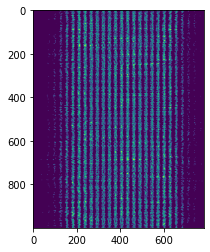

In [24]:
plt.imshow(X2_rotate)

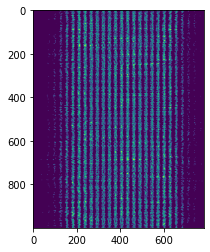

In [23]:
plt.imshow(X2)

In [1]:
# we use this script in the paper to make the corruption experiment.
from sklearn import datasets, neighbors
from scipy import stats
import numpy as np
import harmonicalignment
import harmonicalignment.math

from shutil import copyfileobj
from six.moves import urllib
import os


def knnclassifier(X, X_labels, Y, Y_labels, knn): #输出的是测试的准确率
    knn_op = neighbors.KNeighborsClassifier(knn)
    knn_op.fit(X, X_labels)
    return knn_op.score(Y, Y_labels)


np.random.seed(42)
digits = datasets.fetch_openml("mnist_784")
labels = digits["target"]
# imgs = digits["data"]
imgs = np.asarray(digits["data"])

n_samples = 1000
n_features = 784
n_iters = 1
n_percentages = 3
n_wavelets = 2

colreplace_probs = np.linspace(0, 1, n_percentages) if n_percentages > 1 else [1]
# scale of wavelets(eg n_filters) to use 要使用的小波规模（例如n_filters）。
wavelet_scales = [2, 8, 16, 64]
# kernel params 内核参数
knn_1 = 20
decay_1 = 20
pca_1 = 100
knn_2 = knn_1
decay_2 = decay_1
pca_2 = pca_1
# Z = transformed
knn_transform = 10
decay_transform = 10
pca_transform = None
# diffusion time for final embedding 最终嵌入的扩散时间
diffusion_t = 1
#
output = np.zeros((n_percentages, n_iters, n_wavelets, 2))
# store metrics in here 在这里存储指标
##


In [2]:
n_percentages

3

In [11]:
n_features

784

In [13]:
# np.floor(pct * n_features).astype(int)
pct

0.0

In [10]:
colreplace_probs

array([0. , 0.5, 1. ])

In [16]:
p=1

In [17]:
pct = colreplace_probs[p]
random_rotation = stats.ortho_group.rvs(n_features)
# random orthogonal rotation 随机正交旋转
colReplace = np.random.choice(
    n_features, np.floor(pct * n_features).astype(int), replace=False
)
random_rotation[:, colReplace] = np.eye(n_features)[:, colReplace]

array([[-7.99958796e-03, -5.49980481e-02,  0.00000000e+00,
        -6.26330881e-02, -1.39997096e-02,  3.79162005e-02,
        -5.25505934e-02,  0.00000000e+00,  0.00000000e+00,
         2.35071505e-02],
       [-1.55079335e-02,  2.86173600e-02,  0.00000000e+00,
        -6.30756166e-03, -3.32598631e-02,  5.66592025e-02,
         8.98150546e-03,  0.00000000e+00,  0.00000000e+00,
        -5.08714383e-02],
       [-1.54973727e-02, -2.00042789e-02,  1.00000000e+00,
        -3.32074006e-02,  4.52233816e-02,  1.05264226e-01,
        -4.09724607e-02,  0.00000000e+00,  0.00000000e+00,
         1.67018371e-02],
       [ 3.90198863e-02, -7.56269003e-03,  0.00000000e+00,
         4.96222395e-02, -6.59880428e-02,  4.43645101e-02,
        -7.47047828e-02,  0.00000000e+00,  0.00000000e+00,
        -5.49695197e-02],
       [ 2.22294390e-02, -1.55940967e-02,  0.00000000e+00,
         3.62828845e-02, -2.25655784e-02, -1.71650271e-02,
        -2.60047830e-02,  0.00000000e+00,  0.00000000e+00,
         5.

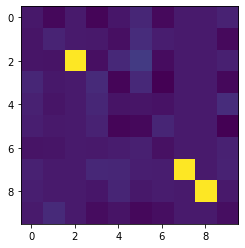

In [22]:
import matplotlib.pyplot as plt
t=10
plt.imshow(random_rotation[:t,:t])
random_rotation[:t,:t]

In [25]:
iter_idx=0

In [27]:
#  sample two sets of digits from MNIST 从MNIST中抽取两组数字
sample_idx = np.random.choice(len(labels), n_samples * 2, replace=False)
X1_idx = sample_idx[:n_samples]
X2_idx = sample_idx[n_samples:]
#  slice the digits 分割数字
X1 = imgs[X1_idx, :]
X2 = imgs[X2_idx, :]
#  transform X2 转化X2
X2_rotate = X2 @ random_rotation.T # 这里的rotation完全就是单位矩阵。
print(f"np.sum((X2_rotate != X2)*1)={np.sum((X2_rotate != X2)*1)}")

np.sum((X2_rotate != X2)*1)=784000


In [32]:
X2_rotate.shape

(1000, 784)

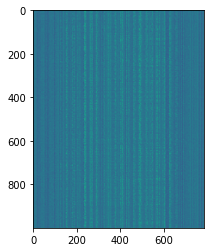

In [31]:
plt.imshow(X2_rotate)